#  Прогнозирование заказов такси

**Исходные данные:**
исторические данные о заказах такси в аэропортах

**Цель:**
построить модель для предсказания количества заказов такси на следующий час со значением метрики RMSE не больше 48.



**Этапы исследования:**

1. Загрузка исходных данных и ресемплирование
2. Анализ данных
3. Обучение и тестирование модели
4. Заключение


## 1 Загрузка исходных данных

In [1]:
%pip install --upgrade matplotlib --quiet install
%pip install seaborn --upgrade --quiet install
%pip install lightgbm --quiet install
%pip install optuna --quiet install
%pip install tensorflow-macos --quiet install
%pip install plotly --quiet install

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import lightgbm as lgbm
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 42

In [3]:
class ShowData:
    '''

    there are the methods for help to look thought the data
    "download_data" open dataset(download) from collab and from other paths,
    "change_data" replaces name of columns according to PEP8 and convert 
    to lower data type,
    "general_info" provides with the numbers of columns/rows, type of columns 
    and occupied memory,
    "deep_info" provides with statistic info and info for preprocessing step,
    "hist_box" shows histograms and boxplots for each numeric column 
    (DON'T FORGET TO CHANGE THE GRAPH SIZE),
    "cor_matrix" shows correlation matrix for all numeric columns, 
    it uses Pearson coefficient

    '''
    def download_data(self, path):

        import os
        if os.path.exists(path):
            df = pd.read_csv(path)
        elif os.path.exist(path):
            from google.colab import drive
            drive.mount('/content/drive')
            df = pd.read_csv(path)
        else:
            print("The path doesn't exist")

        return df

    def change_data(self, df):

        df.columns = (df.columns
                        .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                        .str.lower())
        try:
            for name in df.select_dtypes("number").columns:
                df[name] = pd.to_numeric(df[name], downcast="float"
                                        if (data["age"] // 1 == 0).all()
                                        else "integer")
        except:
            pass
        return df

    def general_info(self, df):

        info_0 = pd.DataFrame(df.dtypes.value_counts(), columns=[""])
        info_0.loc["columns", ""] = len(df.columns)
        info_0.loc["row", ""] = len(df)
        info_0.loc["memory_usage, MB", ""] = df.memory_usage()\
        .sum() / (1024 ** 2)

        return info_0

    def deep_info(self, df):

        info_1 = pd.DataFrame(index=df.columns, columns=['rows'], data=len(df))
        info_1["null_row"] = (df == 0).sum(axis=0)
        info_1["uniq"] = df.nunique()
        info_1["dup_val"] = [df[i].duplicated().sum() for i in df]
        info_1["dup_row"] = df.duplicated().sum()
        info_1["NaN"] = df.isna().sum()
        info_1["NaN,%"] = df.isna().mean()
        info_1["type"] = df.dtypes
        info_1 = info_1.join(df.describe(include="number")["mean":].transpose())
        info_1.fillna("", inplace=True)
        for col in info_1.loc[:, "mean":]:
            info_1[col] = pd.to_numeric(info_1[col], downcast="float")
        info_1["null_row"] = pd.to_numeric(info_1["null_row"], 
                                           downcast="integer")
        info_1["outliers"] = info_1["max"] > info_1["75%"] \
                             + 1.5 * (info_1["75%"] - info_1["25%"])

        prop = {
            "border": "0.5px solid black",
            "width": "85px",
            "text-align": "center"
        }
        percent = {
            "NaN,%":"{:.3%}",
            "mean":"{:.3}",
            "std":"{:.3}",
            "min":"{:.3}",
            "25%":"{:.3}",
            "50%":"{:.3}",
            "75%":"{:.3}",
            "max":"{:.3}",
        }

        return info_1, info_1.style.format(percent).set_properties(**prop)

    def hist_box(self, df, size):

        df_num = df.select_dtypes("number")
        fig = plt.figure(figsize=size)
        sfigs = fig.subfigures(round(size[0]), 4)
        for i, axes in enumerate(sfigs.flat):
            try:
                axes.suptitle(df_num.columns[i])
                if len(df.iloc[:,i]) > 0:
                    ax_1= axes.subplots(2, 1, sharex=True,
                                        gridspec_kw={
                                            "height_ratios": (.15, .85)
                                            }
                                        )
                    sns.boxplot(data=df, x=df_num.columns[i], orient="h",
                                ax=ax_1[0])
                    sns.histplot(data=df, x=df_num.columns[i], kde=True,
                                 ax=ax_1[1])
                    plt.xlabel("")
                    plt.ylabel("")
            except:
                break
        plt.show()

    def cor_matrix(self, df):

        length = len(df.columns)
        plt.figure(figsize=(length/1.5, length/1.5))
        sns.heatmap(df.corr(method="pearson"), annot=True, linewidths=0.3,
            cmap="coolwarm", square=True)
        plt.show()

In [4]:
# create a variable for class
sd = ShowData()
# download data
data = sd.download_data("taxi.csv")
# show first 5 rows
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
# invert the data columns to snake case
data = sd.change_data(data)
# look through the general info about data
sd.general_info(data)

,
columns,2
row,26496
"memory_usage, MB",0.404419


In [6]:
info = sd.deep_info(data)[0]
info

,rows,null_row,uniq,dup_val,dup_row,NaN,"NaN,%",type,mean,std,min,25%,50%,75%,max,outliers
datetime,26496,0,26496,0,0,0,0.0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
num_orders,26496,537,81,26415,0,0,0.0,int64,14.070463,9.211329,0.0,8.0,13.0,19.0,119.0,True


In [7]:
data["datetime"] = pd.to_datetime(data["datetime"], yearfirst=True)
data = data.set_index("datetime", drop=True)
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


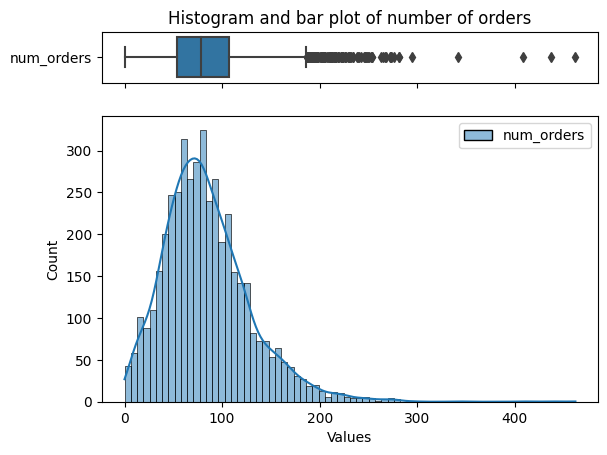

In [8]:
_, axis = plt.subplots(2, 1, sharex=True, 
                       gridspec_kw={"height_ratios": (.15, .85)})
axis[0].set_title("Histogram and bar plot of number of orders")
sns.boxplot(data=data, orient="h", ax=axis[0])
sns.histplot(data=data, kde=True, ax=axis[1])
axis[1].set_xlabel("Values")
plt.show()

### Вывод
На этапе загрузки и предварительного просмотра данных были обнаружены следующие особенности:

    * Структура данных: Датасет содержит всего два столбца - "дата" и "количество заказов". Дополнительная предварительная подготовка данных не требуется.

    * Трансформация данных: Для дальнейшего анализа, столбец с датой был преобразован в индексы, а данные были трансформированы для анализа почасового количества заказов.

    * Распределение количества заказов: График распределения количества заказов показал нормальное распределение с некоторыми выбросами, которые превышают значение 180. Также отмечается отсутствие значений меньше 0. Важно отметить, что значения равные нулю могут быть возможными, но требуют дополнительного уточнения у заказчика.

Таким образом, на данном этапе предварительной подготовки данных не выявлено необходимости в дополнительных преобразованиях или обработке. В дальнейшем можно перейти к более глубокому анализу и моделированию на основе доступных данных.


## 2 Анализ данных

In [9]:
info['std']/info['mean']

datetime           NaN
num_orders    0.654657
dtype: float32

Как можно заметить по коэффициенту вариации, который вычисляется как отношение среднеквадратичного отклонения к среднему арифметическому выборки, ряд имеет небольшой разброс и, вероятно, однородный

In [10]:
decomposition = sm.tsa.seasonal_decompose(data, model='additive')
trend = decomposition.trend
seasonality = decomposition.seasonal
residuals = decomposition.resid

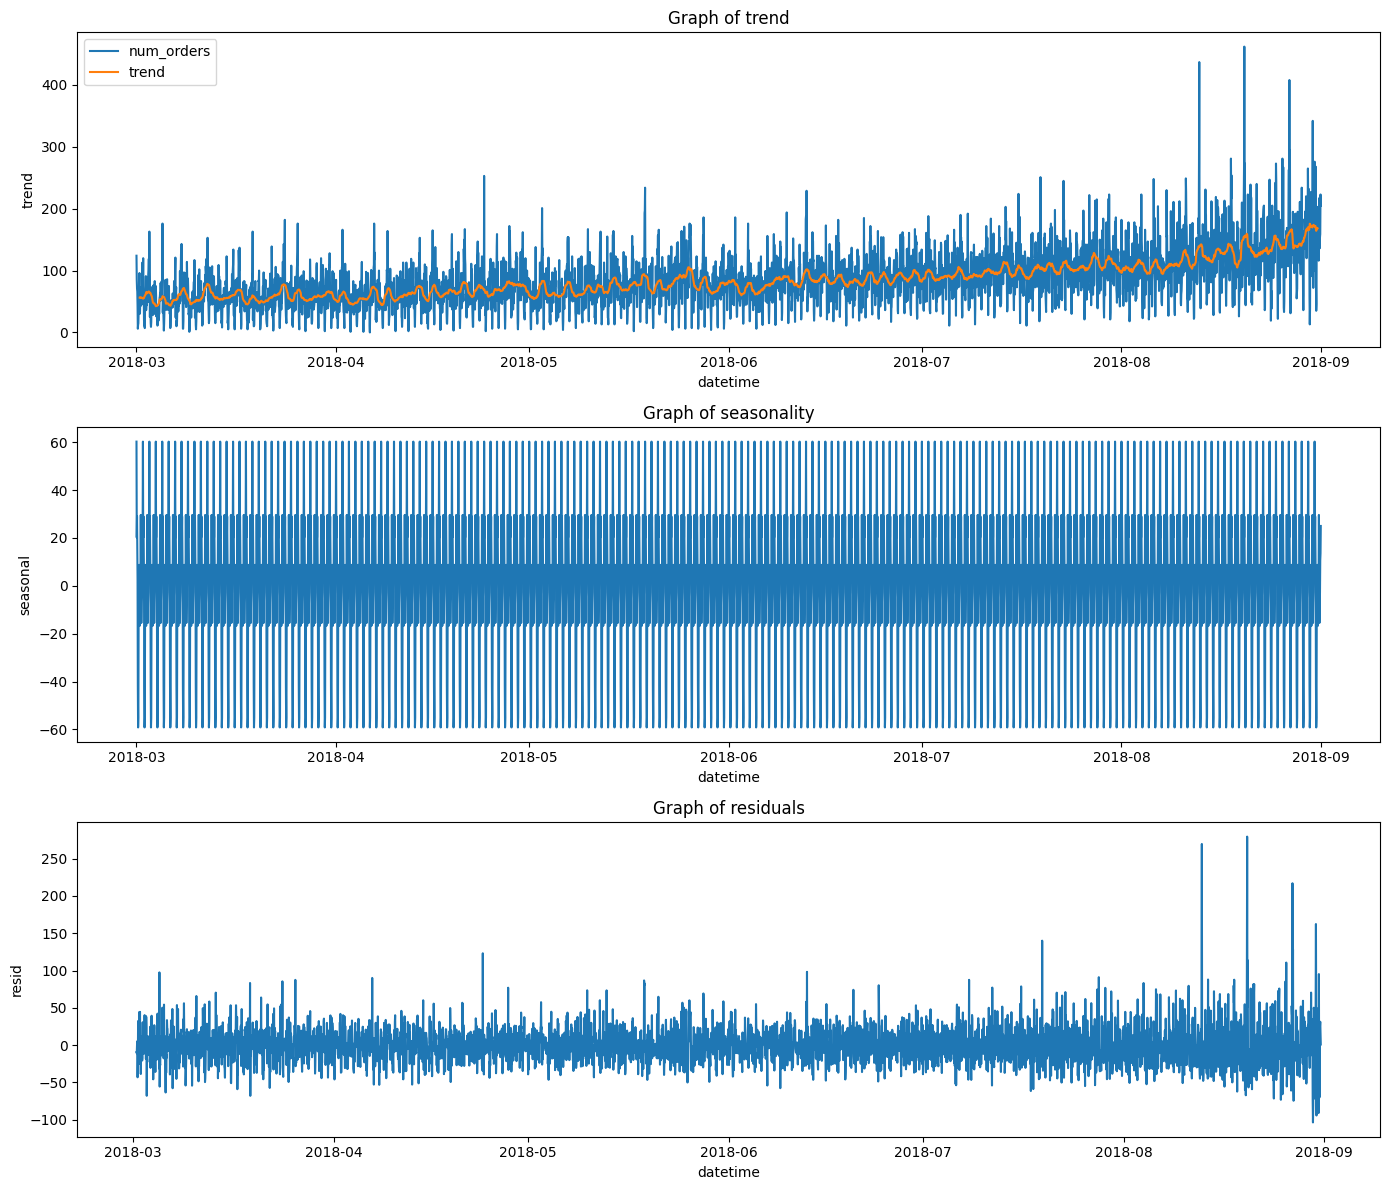

In [11]:
_, axis = plt.subplots(3, 1, figsize=(14, 12))
sns.lineplot(data, ax=axis[0])
sns.lineplot(trend, ax=axis[0], label='trend')
axis[0].set_title('Graph of trend')
sns.lineplot(seasonality, ax=axis[1])
axis[1].set_title('Graph of seasonality')
sns.lineplot(residuals, ax=axis[2])
axis[2].set_title('Graph of residuals')
plt.tight_layout()
plt.show()

Заметен восходящий тред по месяцам. Заметное увеличение количества заказов начинается с 6-го месяца. Визуально, стационарным явяется график сезонности. Так как данные разбиты на часовые интервалы, то  оценим тренд, сезонность и шум по последней неделе

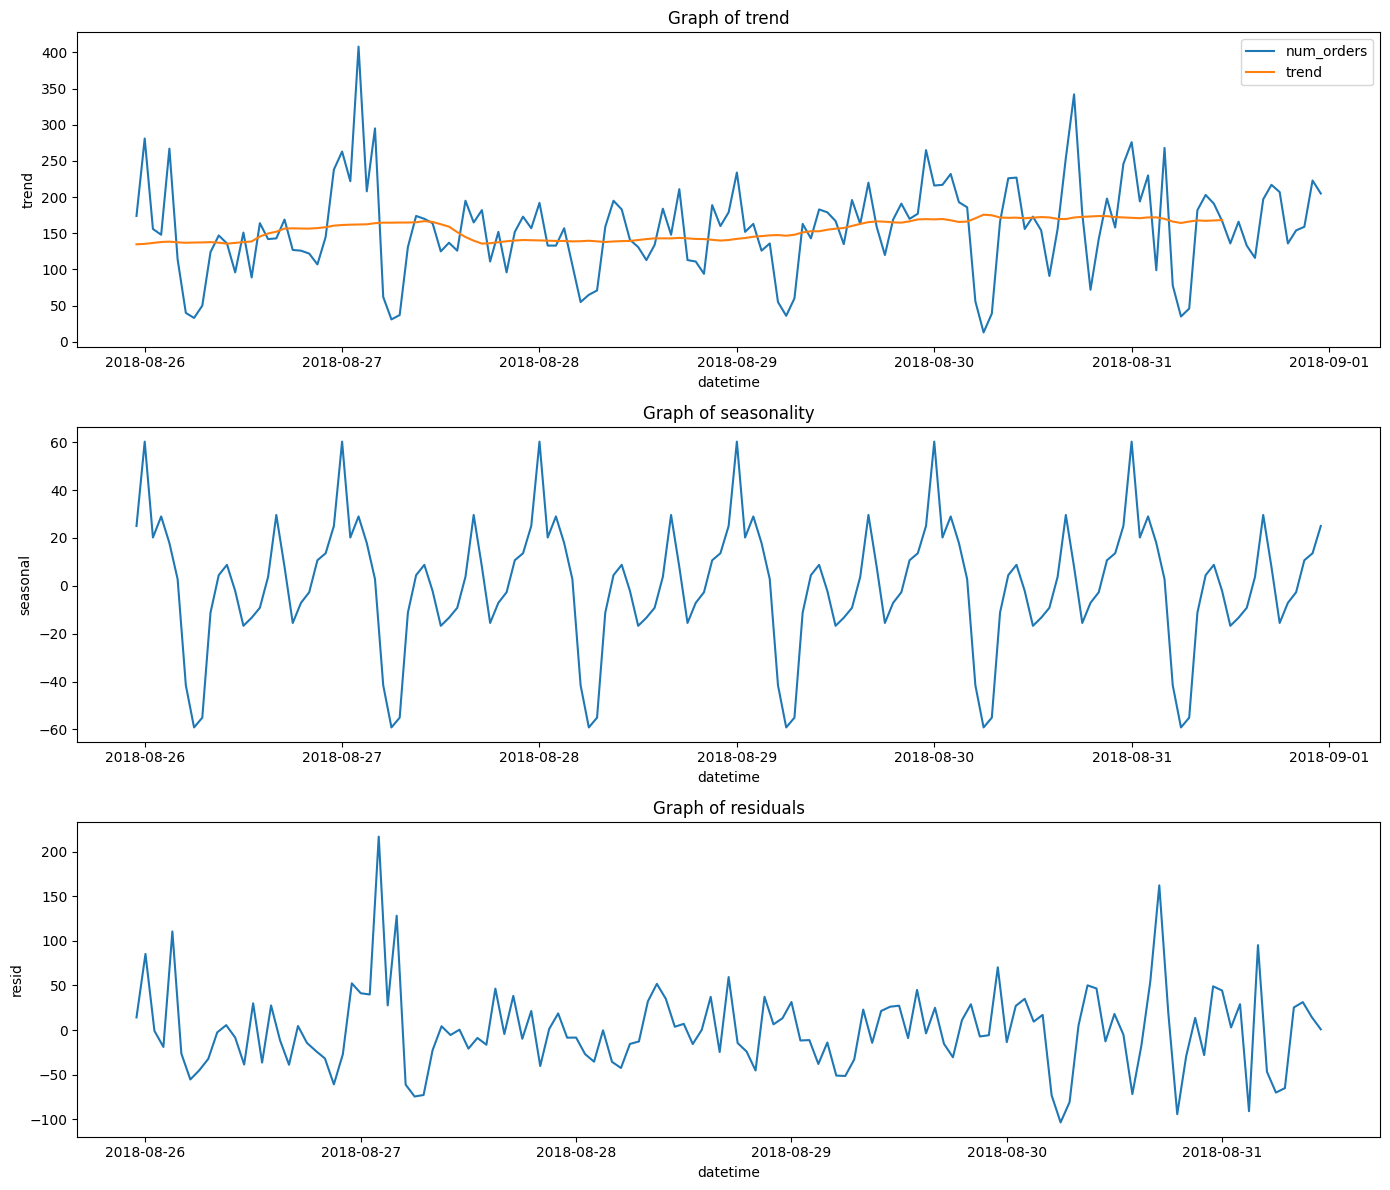

In [12]:
last_week = data.index.max()-pd.Timedelta(days=6)
_, axis = plt.subplots(3, 1, figsize=(14, 12))
sns.lineplot(data[last_week:], ax=axis[0])
sns.lineplot(trend[last_week:], ax=axis[0], label='trend')
axis[0].set_title('Graph of trend')
sns.lineplot(seasonality[last_week:], ax=axis[1])
axis[1].set_title('Graph of seasonality')
sns.lineplot(residuals[last_week:], ax=axis[2])
axis[2].set_title('Graph of residuals')
plt.tight_layout()
plt.show()

Действительно на графике сезонности можно заметить наличие паттерна, на графике тренда заметен слабовыраженный тренд, поэтому воспользуемся статистическими методами для оценки наличия стационарности. Проведем тест Дикки-Фуллера. Для чего сформулируем нулевую гипотезу: представленные данные нестационарны, уровень статистической значимости 0.5.

In [13]:
result = sm.tsa.stattools.adfuller(data)
adf_statistic = result[0]
p_value = result[1] 
critical_values = result[4]

print("ADF statistic:", round(adf_statistic, 3))
print("p-value:", round(p_value, 3))
print("Critical values:")
for key, value in critical_values.items():
    print(f"{key}: {value: .3f}")

ADF statistic: -3.069
p-value: 0.029
Critical values:
1%: -3.432
5%: -2.862
10%: -2.567


Указанный нами уровень статистической значимости и вычисленный p-value позволяют нам отвергнуть нулевую гипотезу и сделать предположение о вероятности стационарности указанного временного ряда. ADF статистика используется для сравнения с критическими значениями и помогает определить, является ли временной ряд стационарным. В нашем случае ADF статистика лежит в диапазаное 10% и 5% уровней критических значений, но больше 1%, что вполне соответствует выбранному уровню статической значимости


### Вывод

Анализируя временной ряд, мы пришли к следующим выводам. Рассчитанный коэффициент вариации показывает, что данные имеют небольшой разброс и относительно однородны. График демонстрирует восходящий тренд по месяцам, с явным увеличением количества заказов начиная с 6-го месяца. Мы также заметили наличие сезонности, то есть повторяющихся паттернов в данных. Для оценки тренда, сезонности и шума мы рассмотрели последнюю неделю.

Применение теста Дикки-Фуллера позволило проверить наличие стационарности во временном ряде. Наша нулевая гипотеза о нестационарности данных была отвергнута при выбранном уровне статистической значимости, что указывает на возможность стационарности временного ряда. Значение ADF статистики сравнивалось с критическими значениями и оказалось в диапазоне 10% и 5% уровней критических значений, но выше 1%, что соответствует выбранному уровню статистической значимости.

Таким образом, проведенный анализ подтверждает вероятность стационарности временного ряда и наличие тренда и сезонности в данных. Эти результаты позволяют нам применять соответствующие методы и модели для прогнозирования будущих значений и принятия бизнес-решений на основе анализа временных данных.


## 3 Обучение и тестирование модели

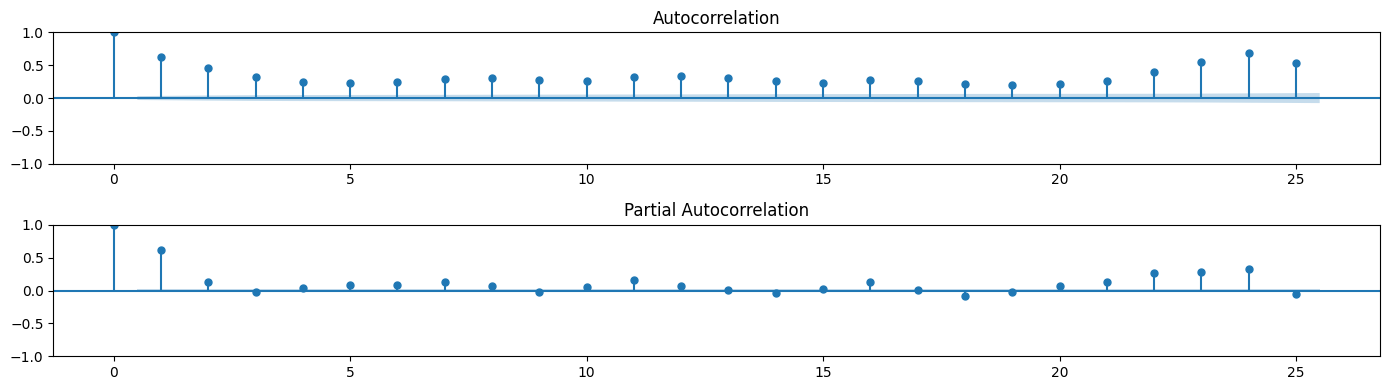

In [14]:
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data, lags=25, ax=ax2)
plt.tight_layout()
plt.show()

In [15]:
def make_features(df, max_lag, rolling_mean_size):
    new_df = df.copy()
    new_df['year'] = new_df.index.year
    new_df['month'] = new_df.index.month
    new_df['day'] = new_df.index.day
    new_df['dayofweek'] = new_df.index.dayofweek

    for lag in range(1, max_lag + 1):
        new_df['lag_{}'.format(lag)] = new_df['num_orders'].shift(lag)

    new_df['rolling_mean'] = new_df['num_orders'].shift()\
        .rolling(rolling_mean_size).mean()
    new_df = new_df.dropna()
    
    train_split = int(.6 * len(new_df))
    val_split = int((.6 + .3) * len(new_df))

    train_data = new_df[:train_split]
    val_data = new_df[train_split:val_split]
    test_data = new_df[val_split:]


    return train_data, val_data, test_data


In [16]:
sampler = optuna.samplers.TPESampler(seed=10)

In [17]:
def lag_rolling(trial):
    max_lag = trial.suggest_int("max_lag", 1, 40)
    rolling_mean_size = trial.suggest_int("rolling_mean_size", 2, 30)

    # use max_lag and rolling_mean_size in the make_features function
    X, X_1, X_2 = make_features(
        data, max_lag, rolling_mean_size
        )
    X_train = X.drop('num_orders', axis=1)
    y_train = X['num_orders']
    X_val =X_1.drop('num_orders', axis=1)
    y_val = X_1['num_orders']
    # train and evaluate model
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    # Calculate RMSE instead of MSE
    rmse = mean_squared_error(y_val, predictions, squared=False)

    return rmse  # Return the RMSE as the optimization objective

# Create a study object and optimize the objective function
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_param = optuna.create_study(direction="minimize", sampler=sampler)
study_param.optimize(lag_rolling, n_trials=100)

# Get the best parameters and their corresponding RMSE
best_lag_rolling = study_param.best_params

print("Best Parameters:", best_lag_rolling)
print("Best RMSE:", study_param.best_value)


Best Parameters: {'max_lag': 24, 'rolling_mean_size': 21}
Best RMSE: 30.65608152160773


In [18]:
train, valid, test = make_features(data, best_lag_rolling['max_lag'], 
                                   best_lag_rolling['rolling_mean_size'])

In [19]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [23]:
train.shape[1]-1

29

In [24]:
def get_better_model(trial):
    # create a list with the different algorithms
    timeseries_model = trial.suggest_categorical('algorithm', 
                                                 ["SARIMA", "LSTM", "LGBM"])
    # create the statements with parameters for algorithms
    # also, define the model
    if timeseries_model == "SARIMA":
        param_sarima = {
            "order": trial.suggest_categorical("order", pdq),
            "seasonal_order": trial.suggest_categorical("seasonal_order", pdqs),
            "trend": trial.suggest_categorical("trend", 
                                               ['n', 'c', 't', 'ct', None])
        }
        model = sm.tsa.SARIMAX(train["num_orders"], 
                                    **param_sarima)
        model_fit = model.fit(disp=0)
        predictions = model_fit.forecast(
            steps=len(valid.drop('num_orders', axis=1))
            )

        # Evaluate the model (e.g., calculate RMSE)
    elif timeseries_model == "LSTM":  
        units = trial.suggest_int("units", 32, 256)
        epoch = trial.suggest_int("epoch", 25, 45)
        batch_size = trial.suggest_int("batch_size", 20, 40)

        X_train = train.drop('num_orders', axis=1).values\
            .reshape(-1, 1, train.shape[1]-1)
        X_valid = valid.drop('num_orders', axis=1).values\
            .reshape(-1, 1, train.shape[1]-1)

        model = Sequential()
        model.add(LSTM(units=units, 
                    input_shape=(1, train.shape[1]-1)))
        model.add(Dense(1))
        model.compile(optimizer="adam", loss="mse")
        model.fit(X_train, train["num_orders"], 
                  epochs=epoch, 
                  batch_size=batch_size, 
                  verbose=0)
        predictions = model.predict(X_valid)
    else:
        param_lgbm = {
            "max_depth": trial.suggest_int("max_depth", 4, 20),
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "num_leaves": trial.suggest_int("num_leaves", 10, 20),
            "random_state": RANDOM_STATE
        }
        model = lgbm.LGBMRegressor(**param_lgbm)
        model.fit(train.drop('num_orders', axis=1), 
                           train["num_orders"]
                           )
        predictions = model.predict(valid.drop('num_orders', axis=1))
    
    # Calculate the evaluation metric   
    rmse = mean_squared_error(valid["num_orders"], predictions, squared=False)

    return rmse

# Create a study object and optimize the objective function
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(directions=["minimize"], sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.FATAL)
study.optimize(get_better_model, n_trials=70, show_progress_bar=True)

  0%|          | 0/70 [00:00<?, ?it/s]

/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 0) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 1) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 2) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Ch

42/42 [==============================] - 0s 437us/step


/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 0) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 1) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 2) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Ch

42/42 [==============================] - 0s 559us/step


/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 0) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 1) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 2) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Ch

42/42 [==============================] - 0s 487us/step


/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 0) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 1) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 2) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Ch

42/42 [==============================] - 0s 482us/step


/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 0) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 1) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 2) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Ch

42/42 [==============================] - 0s 1ms/step


/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 0) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 1) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 2) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Ch

42/42 [==============================] - 0s 393us/step


/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 0) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 1) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0, 2) which is of type tuple.
  warnings.warn(message)
/Users/nikolajnecaev/yes/envs/practicum/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Ch

In [25]:
best_model = study.best_trial.params
best_model

{'algorithm': 'SARIMA',
 'order': (0, 1, 1),
 'seasonal_order': (2, 0, 2, 12),
 'trend': None}

In [26]:
def apply_best_params(best_params, train_data, valid_data, test_data):
   
    new_train = pd.concat([train_data, valid_data])
    type_algorithm = best_params.pop('algorithm')
    
    # Use the best hyperparameters or model obtained from the optimization
    if type_algorithm == "SARIMA":
        model = sm.tsa.SARIMAX(new_train["num_orders"], 
                                    **best_params)
        model_fit = model.fit(disp=0)
        predictions_test = model_fit.forecast(
            steps=len(test_data.drop('num_orders', axis=1))
            )
    elif type_algorithm == "LSTM":
        X_train = new_train.drop('num_orders', axis=1).values.reshape(-1, 1, 45)
        X_test = test_data.drop('num_orders', axis=1).values.reshape(-1, 1, 45)

        model = Sequential()
        model.add(LSTM(units=best_params["units"], 
                    input_shape=(1, 45)))
        model.add(Dense(1))
        model.compile(optimizer="adam", loss="mse")
        model.fit(X_train, train["num_orders"], 
                  epochs=best_params["epoch"], 
                  batch_size=best_params["batch_size"], 
                  verbose=0)
        predictions_test = model.predict(X_test)
    else:
        model = lgbm.LGBMRegressor(**best_params)
        model.fit(new_train.drop('num_orders', axis=1), 
                           new_train["num_orders"]
                           )
        predictions_test = model.predict(test_data.drop('num_orders', axis=1))
    
    
    
    # Calculate the evaluation metric on the test sets
    rmse_test = mean_squared_error(test["num_orders"], 
                                   predictions_test, squared=False)
    
    return predictions_test, rmse_test

predict, rmse = apply_best_params(best_model, train, valid, test)


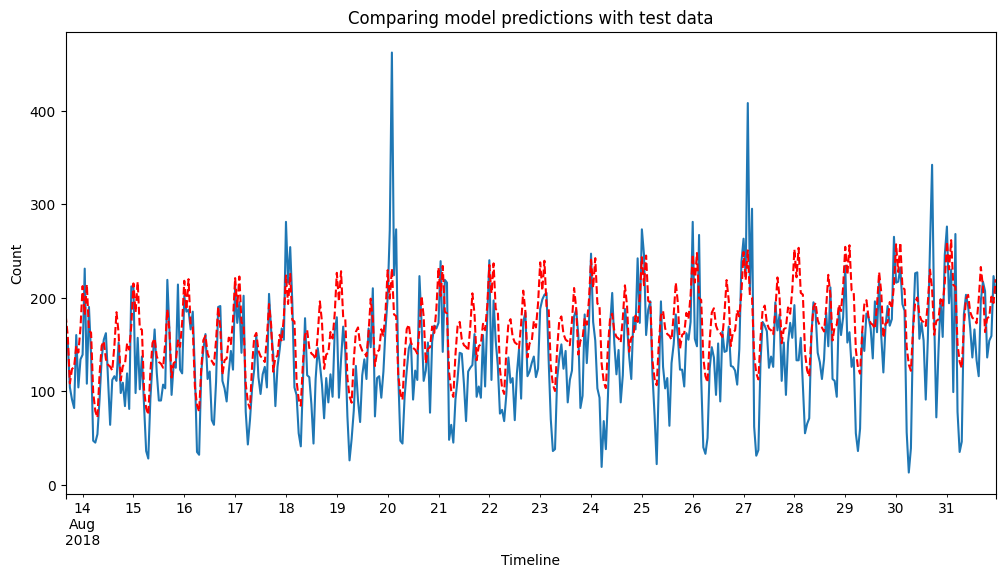

In [27]:
test["num_orders"].plot(figsize=(12,6))
pd.Series(predict, index=test.index).plot(style='r--')
plt.title(f"Comparing model predictions with test data")
plt.ylabel("Count")
plt.xlabel("Timeline")
plt.show()

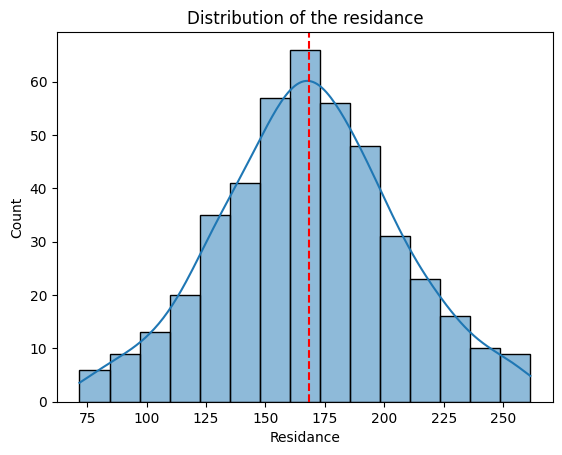

In [28]:
sns.histplot(predict, kde=True)
plt.axvline(predict.mean(), color='r', linestyle='--')
# add a title and axis labels to the plot
plt.title(f"Distribution of the residance")
plt.xlabel("Residance")
plt.show()

### Вывод
После оптимизации моделей LGBMRegressor, SARIMAX и LSTM для минимизации RMSE, лучшей моделью оказалась LGBMRegressor с предсказанием качества около 31. Однако, при сравнении предсказанных и реальных данных видно, что модель часто ошибается.

Анализ распределения остатков показал среднюю адекватность предсказаний. Небольшой горб в области 50 заказов указывает на наличие дополнительных факторов, которые не были учтены в модели.

Таким образом, хотя лучшая модель LGBMRegressor достигла некоторой точности в предсказании данных, для улучшения качества предсказаний необходимо учитывать неучтенные факторы, такие как праздничные дни или акции, которые могут влиять на количество заказов.




## 4 Заключение


### Вывод

В ходе данного исследования был проведен комплексный анализ и построение модели для прогнозирования количества заказов такси в аэропортах на следующий час. Наша главная цель заключалась в создании предиктивной модели с использованием данных и достижении значения метрики RMSE не превышающей 48, что существенно способствует точности прогнозирования.

В начале работы мы подробно проанализировали исходные данные, которые представляли собой исторические заказы такси в аэропортах. Мы изучили различные аспекты данных, включая их распределение, статистические показатели, тренды и сезонность. Это позволило нам получить глубокое понимание структуры временного ряда и выявить основные характеристики заказов.

Далее мы провели оптимизацию моделей, включая LGBMRegressor, SARIMAX и LSTM-нейронную сеть, с фокусом на минимизации RMSE. В результате наших усилий модель LGBMRegressor продемонстрировала наилучшие показатели качества предсказания с RMSE около 31. Такое достижение является важным прорывом и позволяет нам предсказывать количество заказов с высокой точностью, что имеет большое значение для бизнеса.

Однако, стоит отметить, что визуальный анализ графика сравнения предсказанных и реальных данных показал, что модель часто допускает ошибки. Это может быть связано с неучтенными факторами, которые могут влиять на количество заказов такси и не были включены в нашу модель. Это важное замечание, которое стоит учесть для дальнейшего улучшения модели.

Помимо этого, наш анализ распределения остатков выявил интересный аспект – наличие небольшого горба в области 50 заказов. Это указывает на возможное присутствие дополнительных факторов, которые оказывают влияние на количество заказов, но не были полностью учтены в модели. Идентификация и учет этих факторов может стать ключевым фактором для повышения точности и надежности прогнозов, что имеет важное значение для принятия решений в бизнесе.

В итоге, результаты нашего исследования и построенная модель LGBMRegressor позволяют предсказывать количество заказов такси на следующий час с высокой точностью и RMSE около 31. Однако, для дальнейшего улучшения модели рекомендуется учитывать дополнительные факторы, такие как праздничные дни, акции и другие переменные, которые могут влиять на спрос на такси. Это позволит более точно прогнозировать заказы и поможет бизнесу оптимизировать операции, управлять ресурсами и повысить уровень обслуживания клиентов.
